In [1]:
# Adverse Weather Scenarios for Future Electricity Systems data
# plots etc.

# based on code from Hannah Bloomfield 17th June 2021

# Load in python libraries (libraries may need to be installed first in a virtual environ)
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader
import cartopy
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import xarray as xr

In [2]:
%cd ..

/home/users/train033/Documents/group_2


In [3]:
from energy_functions_22 import mask_xarray, calc_hdd_cdd, calc_demand, alpha_demand_GB

# Read in data (temperature, wind)

In [4]:
# Data repository on CEDA
data_loc = '/gws/pw/j05/cop26_hackathons/oxford/Data/ERA5_data_EU_domain/field_set_1/'
fpath = data_loc

# Read in temperature, windspeed (and solar, ...)
dataset = xr.open_mfdataset(fpath+'ERA5_1hr_field_set_1_201*_*.nc')
dataset['t2m'] -= 273.15 # conversion K to C
dataset['wind_speed'] = np.sqrt(dataset.u100**2 + dataset.v100**2)

In [5]:
# Mask country
COUNTRY = 'United Kingdom'

# first loop through the countries and extract the appropriate shapefile
countries_shp = shpreader.natural_earth(resolution='10m',
                                        category='cultural',
                                        name='admin_0_countries')

country_shapely = None
for country in shpreader.Reader(countries_shp).records():
    if country.attributes['NAME_LONG'] == COUNTRY:
        print(f'Found country: {COUNTRY}')
        country_shapely = country.geometry

Found country: United Kingdom


# Plot temperature, windspeed

In [6]:
dsm, mask = mask_xarray(dataset, country_shapely, ['t2m', 'wind_speed'], 1)

In [7]:
# only keep relevant fields
for k in ['u100', 'v100', 'u10', 'v10', 'mx2t', 'msl', 'mn2t', 'ssrd']:
    del dsm[k]

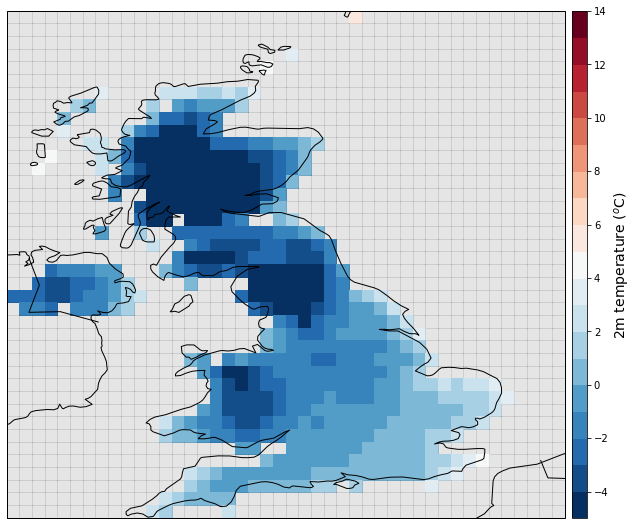

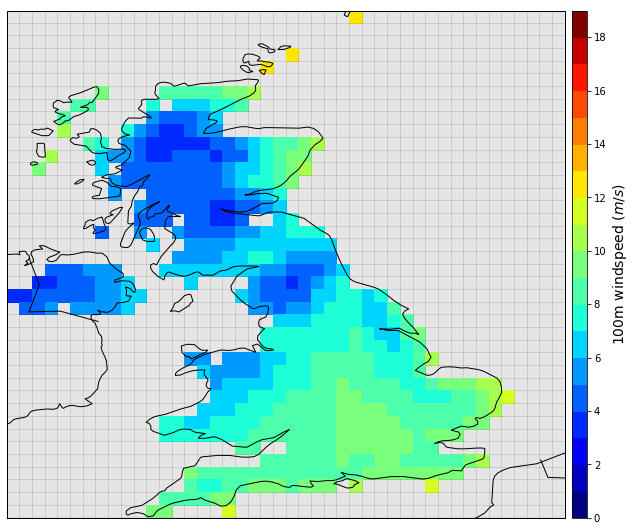

In [8]:
# config (T2M, WS)
time_idxs = [1, 0]
ds=dsm
labels = ['2m temperature ($^{o}$C)', '100m windspeed ($m/s$)']
cmap_list = [plt.cm.RdBu_r, plt.cm.jet]
bounds_list = [np.arange(-5, 15), np.arange(20)]

# setup plot
gridded_lons, gridded_lats = np.meshgrid(ds.longitude, ds.latitude)
subplot_kw={'projection': ccrs.PlateCarree()}

for k, label, bounds, cmap, idx_time in zip(['t2m', 'wind_speed'], labels,
                                  bounds_list, cmap_list, time_idxs):
    fig, ax = plt.subplots(figsize=(10,10), subplot_kw=subplot_kw)
    ax.set_extent([-8, 3, 50, 60], crs=ccrs.PlateCarree())

    # mesh plot
    cmap.set_bad('k', alpha=0.1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    cs = plt.pcolormesh(gridded_lons, gridded_lats, ds[k][idx_time],
                        cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
    # colormap and colorbar
    cax = fig.add_axes([ax.get_position().x1 + 0.01, ax.get_position().y0,
                        0.02, ax.get_position().height])
    cb = plt.colorbar(cax=cax)

    # labels
    ax.set_xlabel('Longitude',fontsize=14)
    ax.set_ylabel('Latitude',fontsize=14)
    #ax.set_title('Example map',fontsize=16)
    cb.ax.set_ylabel(label,fontsize=14)

    # cartopy
    ax.coastlines(resolution='50m')
    ax.add_feature(cartopy.feature.BORDERS)